# t-SNE (Amazon fine food dataset)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import sqlite3
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


import warnings
warnings.filterwarnings('ignore')

In [3]:
con = sqlite3.connect('/home/akash/Downloads/amazon-fine-food-reviews/database.sqlite')

In [4]:
filtered_data = pd.read_sql_query('''select * from Reviews where Score != 3''', con)
filtered_data.shape

(525814, 10)

In [5]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

In [6]:
actual_score = filtered_data['Score']
posneg = actual_score.map(partition)
filtered_data['Score'] = posneg
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending= True, inplace= False, kind= 'quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [10]:
final.shape

(364171, 10)

# pre processing

In [11]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'from', 'whom', 'yourself', 'ain', 'didn', 'those', 'both', "wouldn't", "she's", 'nor', "you've", 'her', 'themselves', 'who', 'has', 'than', 'she', 'herself', 'isn', "you'll", 'been', 'between', 'before', 'or', 'am', "couldn't", 'wouldn', 'himself', 'yourselves', 'just', 'd', 'how', 'wasn', 'itself', 'for', 'on', 'own', 'mightn', 'm', 'what', 'there', 'having', 'a', 'he', 'into', 'no', 'by', 'were', 'needn', "don't", 'because', 'while', 've', 'this', 'an', 'after', "needn't", 'ours', 'they', 'of', 'them', 'again', 'be', 'can', "shan't", 'why', 'then', 'our', 'my', 'is', 'some', 'haven', 'ma', 'over', "that'll", 'll', 'same', 'when', 'such', 'which', 'out', 'are', 'more', "mightn't", 'each', 'did', 'doing', "hasn't", 'in', 're', 'me', 'so', 'hadn', 'shouldn', 'hasn', 'won', 'down', 'where', 'don', "doesn't", 'your', 'under', 'yours', "weren't", 'will', "hadn't", 'ourselves', 'him', 'not', "mustn't", 'was', "you'd", "isn't", 'hers', "it's", 'as', 'few', 'had', 'at', 'with', 'his', 'bein

In [13]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [15]:
print(final.head(3)) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

            Id   ProductId          UserId            ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  Th

# BoW

In [16]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final["CleanedText"].values)
print('Type: ', type(final_counts))
print('shape: ', final_counts.get_shape)
print('No. of unique words: ', final_counts.get_shape()[1])

Type:  <class 'scipy.sparse.csr.csr_matrix'>
shape:  <bound method spmatrix.get_shape of <364171x71624 sparse matrix of type '<class 'numpy.int64'>'
	with 11460537 stored elements in Compressed Sparse Row format>>
No. of unique words:  71624


      Dim1     Dim2     label
0 -4.80003  -3.0932  positive
1 -2.55718  3.58384  positive
2 -12.5293 -6.56388  positive
3  7.19834  3.87993  positive
4 -12.5726 -6.58321  positive
(5000, 3)


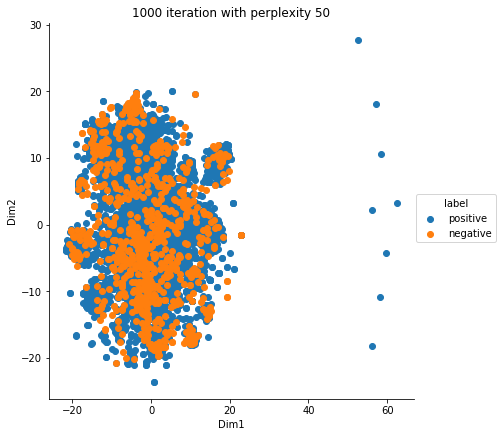

In [16]:
from sklearn.manifold import TSNE

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)

data = final_counts[0:5000,:].toarray()
std_data = scalar.fit_transform(data)
labels=final['Score']

labels_5k = labels[0:5000]

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
tsne_data= model.fit_transform(data)

tsne_data= np.vstack((tsne_data.T, labels_5k)).T
tsne_df= pd.DataFrame(tsne_data, columns=('Dim1','Dim2','label'))

print(tsne_df.head())
print(tsne_df.shape)

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('1000 iteration with perplexity 50')
plt.show()

      Dim1     Dim2     label
0 -4.76548  5.44149  positive
1 -7.10444  5.24291  positive
2 -5.04066  8.42676  positive
3  17.2616   2.4268  positive
4 -5.05618  8.40636  positive
(5000, 3)


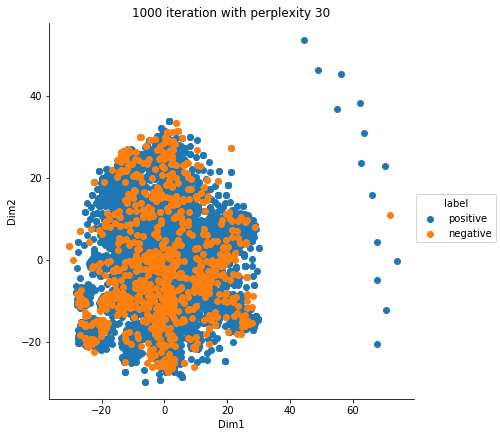

In [17]:
from sklearn.manifold import TSNE

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)

data = final_counts[0:5000,:].toarray()
std_data = scalar.fit_transform(data)
labels=final['Score']

labels_5k = labels[0:5000]

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_data= model.fit_transform(data)

tsne_data= np.vstack((tsne_data.T, labels_5k)).T
tsne_df= pd.DataFrame(tsne_data, columns=('Dim1','Dim2','label'))

print(tsne_df.head())
print(tsne_df.shape)

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('1000 iteration with perplexity 30')
plt.show()

      Dim1     Dim2     label
0 -55.3176  51.9685  positive
1 -96.5344  26.6038  positive
2 -123.056  63.2159  positive
3 -87.2572  9.72101  positive
4 -122.735  63.0771  positive
(5000, 3)


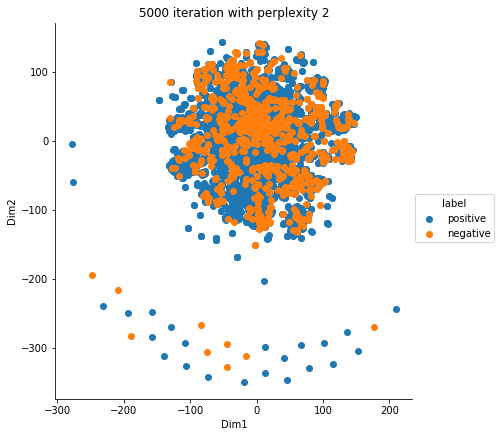

In [17]:
from sklearn.manifold import TSNE

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)

data = final_counts[0:5000,:].toarray()
std_data = scalar.fit_transform(data)
labels=final['Score']

labels_5k = labels[0:5000]

model = TSNE(n_components=2, random_state=0, perplexity=2, n_iter=5000)
tsne_data= model.fit_transform(data)

tsne_data= np.vstack((tsne_data.T, labels_5k)).T
tsne_df= pd.DataFrame(tsne_data, columns=('Dim1','Dim2','label'))

print(tsne_df.head())
print(tsne_df.shape)

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('5000 iteration with perplexity 2')
plt.show()

# TF-IDF

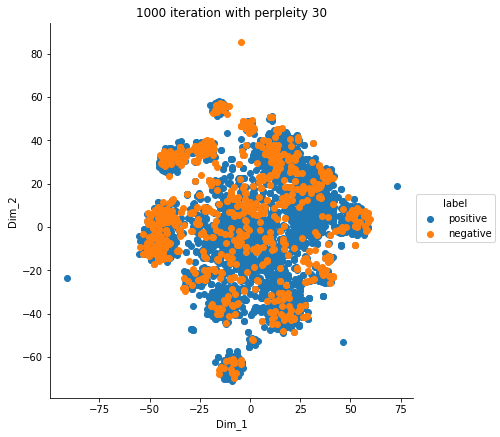

In [16]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(final['CleanedText'].values)

data = final_tfidf[0:5000,:].toarray()
labels = final['Score']
labels_5k = labels[0:5000]

model = TSNE(n_components= 2, random_state= 0, perplexity= 30)
tsne_data= model.fit_transform(data)

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns= ('Dim_1', 'Dim_2','label'))

sns.FacetGrid(tsne_df, hue= 'label', size=6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('1000 iteration with perpleity 30')
plt.show()

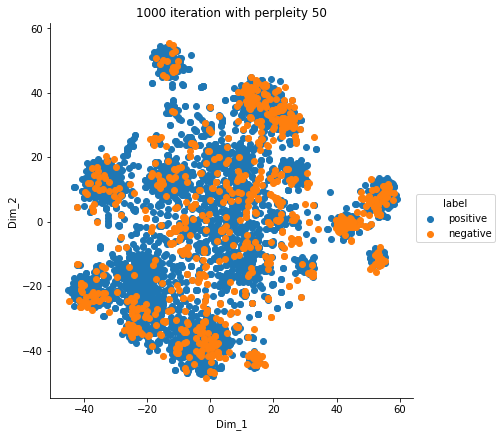

In [18]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(final['CleanedText'].values)

data = final_tfidf[0:5000,:].toarray()
labels = final['Score']
labels_5k = labels[0:5000]

model = TSNE(n_components= 2, random_state= 0, perplexity= 50)
tsne_data= model.fit_transform(data)

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns= ('Dim_1', 'Dim_2','label'))

sns.FacetGrid(tsne_df, hue= 'label', size=6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('1000 iteration with perpleity 50')
plt.show()

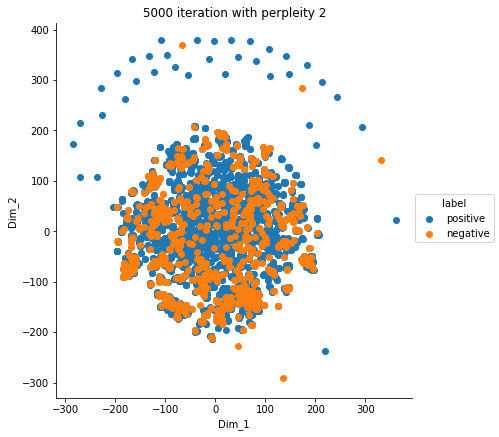

In [30]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(final['CleanedText'].values)

data = final_tfidf[0:5000,:].toarray()
labels = final['Score']
labels_5k = labels[0:5000]

model = TSNE(n_components= 2, random_state= 0, perplexity= 2, n_iter = 5000)
tsne_data= model.fit_transform(data)

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns= ('Dim_1', 'Dim_2','label'))

sns.FacetGrid(tsne_df, hue= 'label', size=6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('5000 iteration with perpleity 2')
plt.show()

# Word2Vec

In [19]:
import pickle
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

i = 0
list_of_sent = []
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [20]:
print(final['CleanedText'].values[0])
print('---------------------------------------------------------------------------')
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
---------------------------------------------------------------------------
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [21]:
w2v_model = Word2Vec(list_of_sent, min_count= 5, size=50, workers=4)

In [22]:
w2v_words = list(w2v_model.wv.vocab)

print('Number of words that occurer minimum 5 times ', len(w2v_words))
print('Sample words ', w2v_words[0:50])

Number of words that occurer minimum 5 times  21938
Sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two']


In [23]:
w2v_model.wv.most_similar('nice')

[('perfect', 0.8164280652999878),
 ('great', 0.7641785144805908),
 ('wonder', 0.7427768707275391),
 ('tasti', 0.6696702837944031),
 ('terrif', 0.6641337871551514),
 ('excel', 0.6626256108283997),
 ('good', 0.6460180282592773),
 ('fantast', 0.6394532918930054),
 ('delic', 0.612546980381012),
 ('light', 0.6102896928787231)]

In [24]:
count_vect_features = count_vect.get_feature_names()

In [25]:
print(count_vect_features)

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaah', 'aaaaaahhh', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhyaaaaaa', 'aaaaaand', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaaallll', 'aaaaawsom', 'aaaah', 'aaaahhhhhh', 'aaaahhhhhhhhhhh', 'aaaallll', 'aaaand', 'aaaannnnddd', 'aaaarrrrghh', 'aaagh', 'aaah', 'aaahhh', 'aaahhhhhh', 'aabout', 'aabsolut', 'aachen', 'aacur', 'aad', 'aadd', 'aadp', 'aadult', 'aaf', 'aafco', 'aafter', 'aagh', 'aah', 'aahh', 'aahhh', 'aalmost', 'aaloo', 'aamazon', 'aamzon', 'aana', 'aand', 'aani', 'aanoth', 'aap', 'aappubl', 'aar', 'aardvark', 'aargh', 'aaron', 'aarp', 'aarrgghhhh', 'aarrgh', 'aarthur', 'aarti', 'aasanfood', 'aauc', 'ab', 'aback', 'abalon', 'abamectin', 'abandn', 'abando', 'abandon', 'abaolut', 'abash', 'abat', 'abattoir', 'abb', 'abba', 'abbay', 'abbazabba', 'abberlin', 'abbey', 'abb

In [26]:
count_vect_features.index('tasti')

62065

In [27]:
print(count_vect_features[64055])

toowould


# Avg W2V

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


In [31]:
sent_vectors = np.array(sent_vectors)
print(type(sent_vectors))
sent_vectors = sent_vectors[0:5000,:]
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
std_data = scalar.fit_transform(sent_vectors) 

<class 'numpy.ndarray'>


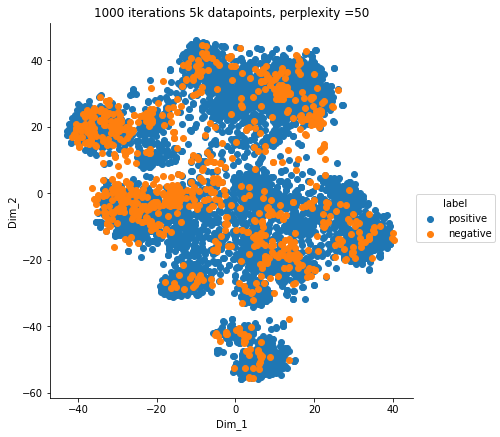

In [32]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = tsne_model.fit_transform(std_data)

labels = final["Score"]
labels_5k = labels[0:5000]

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('1000 iterations 5k datapoints, perplexity =50')
plt.show()

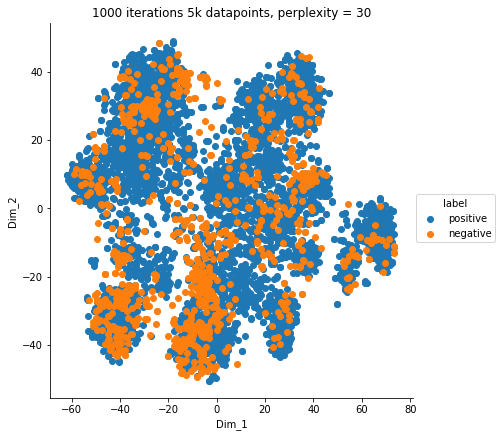

In [34]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = tsne_model.fit_transform(std_data)

labels = final["Score"]
labels_5k = labels[0:5000]

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('1000 iterations 5k datapoints, perplexity = 30')
plt.show()

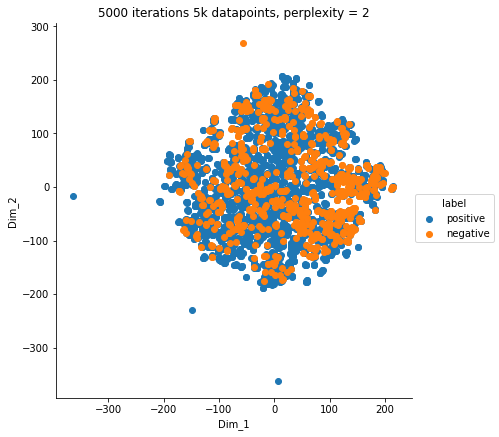

In [35]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=2, n_iter = 5000)
tsne_data = tsne_model.fit_transform(std_data)

labels = final["Score"]
labels_5k = labels[0:5000]

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('5000 iterations 5k datapoints, perplexity = 2')
plt.show()

# TF-IDF weighted Word2Vec

In [28]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(final['CleanedText'].values)
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [34]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
#print(type(sent_vectors))
sent_vectors_5k = tfidf_sent_vectors[0:5000,:]
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
std_data_tfidfw2v = scalar.fit_transform(sent_vectors_5k)

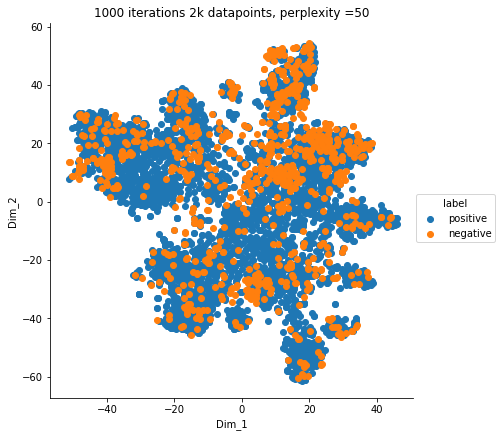

In [35]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = tsne_model.fit_transform(std_data_tfidfw2v)

labels = final["Score"]
labels_5k = labels[0:5000]

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('1000 iterations 2k datapoints, perplexity =50')
plt.show()

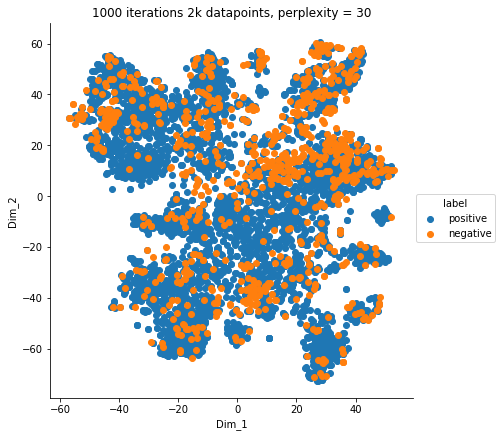

In [36]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = tsne_model.fit_transform(std_data_tfidfw2v)

labels = final["Score"]
labels_5k = labels[0:5000]

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('1000 iterations 2k datapoints, perplexity = 30')
plt.show()

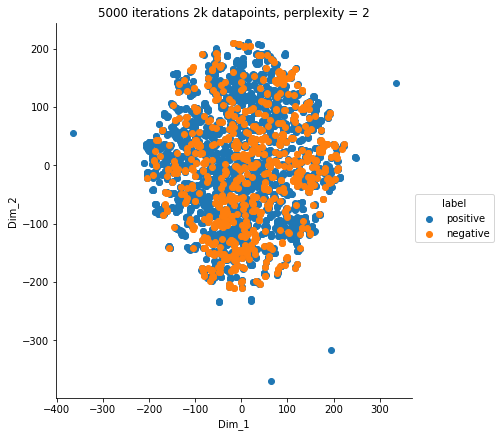

In [37]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=2, n_iter=5000)
tsne_data = tsne_model.fit_transform(std_data_tfidfw2v)

labels = final["Score"]
labels_5k = labels[0:5000]

tsne_data = np.vstack((tsne_data.T, labels_5k)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('5000 iterations 2k datapoints, perplexity = 2')
plt.show()

# Obsevations

It is very much difficult to judge which technique gives the best results with 5k points as all the plots generated show a huge overlapping of points. Hence with 5k data points of the dataset we can not seperate the positive and negative point from each other with a linear function.